# Final Model Training - XGBoost & LightGBM

## Overview
This notebook performs the final model training and optimization:
- Cross-validation for model selection
- Hyperparameter tuning using GridSearchCV
- Model evaluation and comparison
- Model export for production

## Models Trained
1. Decision Tree (baseline)
2. Random Forest
3. XGBoost (optimized)
4. LightGBM (optimized)

## Dataset
- Training: 640 samples
- Testing: 160 samples
- Features: 17 (after one-hot encoding)

In [4]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import os
import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

print("✅ All libraries imported successfully!")

C:\Users\Ikhlas Putra\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully!


## 0. Import Libraries

Import all required libraries for model training and evaluation

## 1. Load Data

Load pre-processed and split dataset (80:20 train:test split)

In [5]:
# Load pre-split and encoded datasets
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

print("✅ Data berhasil dimuat!")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")

✅ Data berhasil dimuat!
Training samples: 640
Testing samples: 160
Number of features: 17


In [6]:
# Initialize models with consistent random state
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

# Configure cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Performing 5-Fold Cross-Validation...\n")
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
    cv_results[name] = scores
    print(f"{name:15s} | R² = {scores.mean():.4f} (±{scores.std():.4f})")

print("\n✅ Cross-validation completed!")

Performing 5-Fold Cross-Validation...

Decision Tree   | R² = 0.8221 (±0.0164)
Random Forest   | R² = 0.8983 (±0.0137)
XGBoost         | R² = 0.8784 (±0.0150)
LightGBM        | R² = 0.8978 (±0.0069)

✅ Cross-validation completed!


## 2. Cross-Validation

Perform 5-fold cross-validation to compare baseline performance

In [7]:
# Define hyperparameter grids for optimization
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 70]
    }
}

print("Starting Hyperparameter Tuning...\n")
best_models = {}

# Optimize XGBoost and LightGBM
for name in ['XGBoost', 'LightGBM']:
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    
    print(f"Best params: {grid.best_params_}")
    print(f"Best CV R²: {grid.best_score_:.4f}\n")

print("✅ Hyperparameter tuning completed!")

Starting Hyperparameter Tuning...

Tuning XGBoost...
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV R²: 0.9055

Tuning LightGBM...
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
Best CV R²: 0.9037

✅ Hyperparameter tuning completed!


## 3. Hyperparameter Tuning

Optimize XGBoost and LightGBM using GridSearchCV

In [8]:
# Train all models on full training set
print("Training all models on full training set...\n")

for name, model in models.items():
    if name in best_models:
        models[name] = best_models[name]
    else:
        models[name].fit(X_train, y_train)

print("✅ All models trained!")

Training all models on full training set...

✅ All models trained!


In [9]:
# Evaluate all models on test set
results = []

print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)
print(f"{'Model':<15} {'R²':<10} {'MAE':<10} {'RMSE':<10} {'MAPE':<10}")
print("-"*80)

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    results.append({
        'Model': name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Predictions': y_pred
    })
    
    print(f"{name:<15} {r2:<10.4f} {mae:<10.4f} {rmse:<10.4f} {mape:<10.2f}%")

print("="*80)

# Identify best model
results_df = pd.DataFrame(results)
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")


MODEL EVALUATION RESULTS
Model           R²         MAE        RMSE       MAPE      
--------------------------------------------------------------------------------
Decision Tree   0.8137     0.5959     0.7308     16.02     %
Random Forest   0.8889     0.4571     0.5643     12.57     %
XGBoost         0.9025     0.4200     0.5287     12.08     %
LightGBM        0.9009     0.4246     0.5329     12.03     %

🏆 Best Model: XGBoost


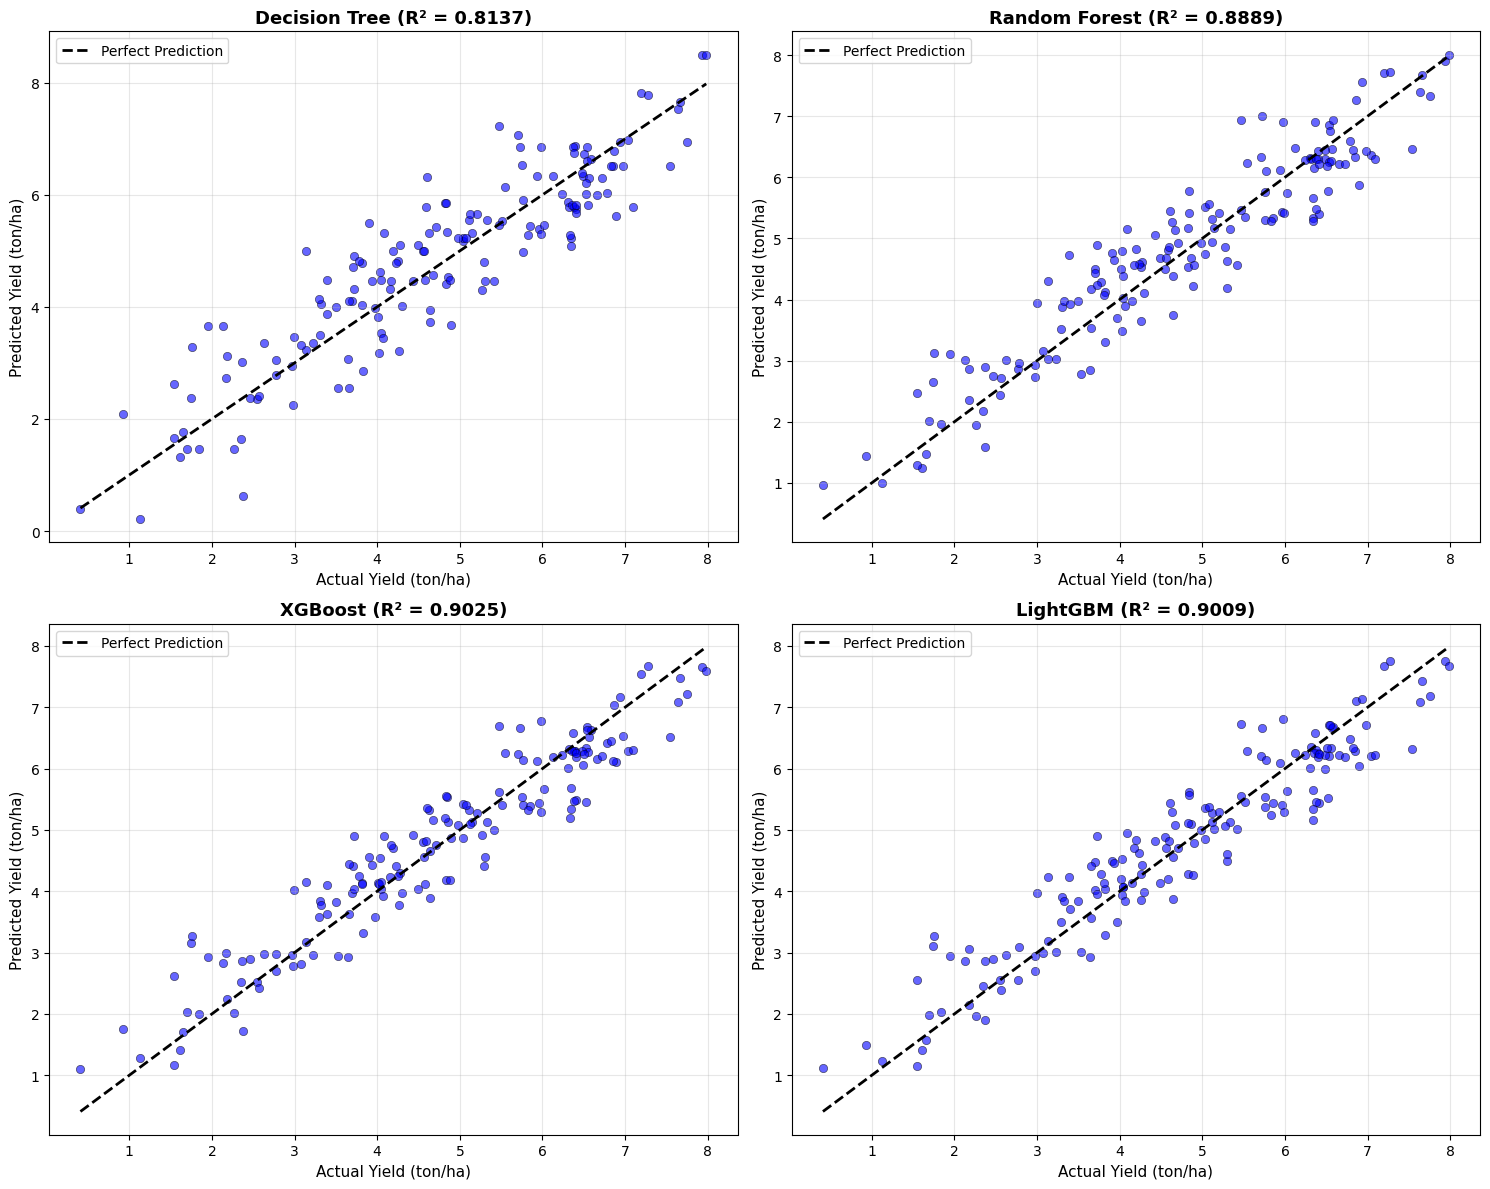

In [10]:
# Create scatter plots comparing actual vs predicted values
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx // 2, idx % 2]
    y_pred = results_df[results_df['Model'] == name]['Predictions'].values[0]
    r2 = results_df[results_df['Model'] == name]['R²'].values[0]
    
    ax.scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolors='black', linewidths=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Yield (ton/ha)', fontsize=11)
    ax.set_ylabel('Predicted Yield (ton/ha)', fontsize=11)
    ax.set_title(f'{name} (R² = {r2:.4f})', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

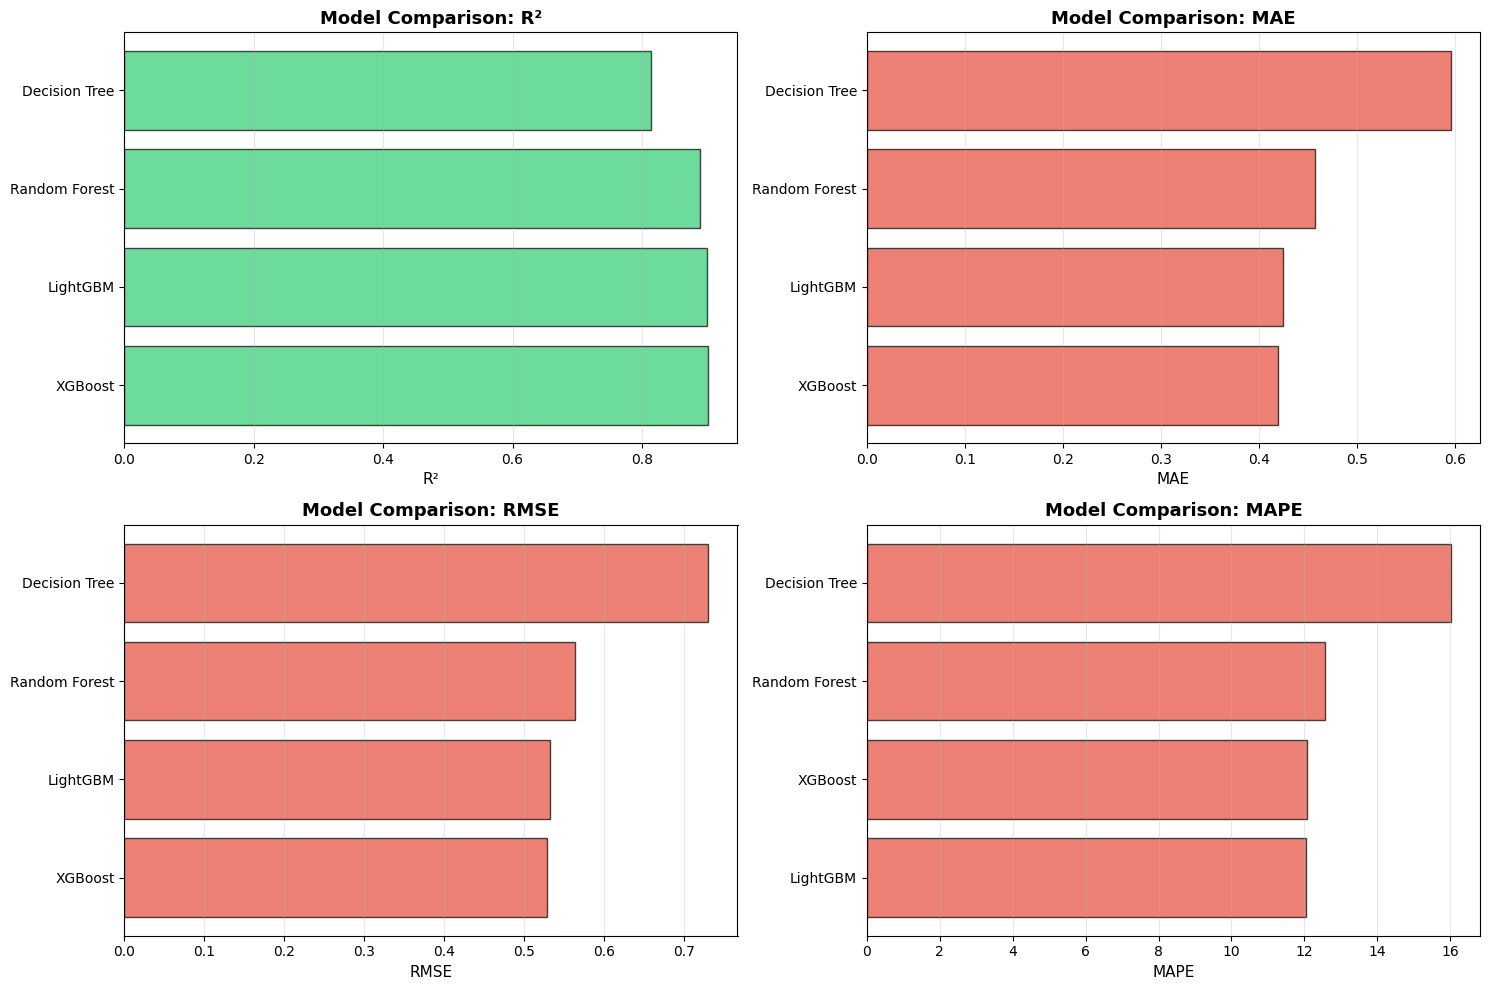

In [11]:
# Visualize model comparison across all metrics
metrics_df = results_df[['Model', 'R²', 'MAE', 'RMSE', 'MAPE']].copy()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, metric in enumerate(['R²', 'MAE', 'RMSE', 'MAPE']):
    ax = axes[idx // 2, idx % 2]
    data = metrics_df.sort_values(metric, ascending=(metric != 'R²'))
    colors = ['#2ecc71' if metric == 'R²' else '#e74c3c'] * len(data)
    ax.barh(data['Model'], data[metric], color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'Model Comparison: {metric}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [12]:
# Initialize SHAP explainer for best model
best_model = models[best_model_name]

print(f"Creating SHAP analysis for {best_model_name}...\n")

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

print("✅ SHAP values computed!")

Creating SHAP analysis for XGBoost...



TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [ ]:
# SHAP Summary Plot - shows feature importance and impact direction
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=16, pad=20, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Interpretasi SHAP Summary Plot:")
print("- Fitur paling atas = paling berpengaruh terhadap prediksi")
print("- Warna MERAH = nilai fitur tinggi")
print("- Warna BIRU = nilai fitur rendah")
print("- Posisi KANAN (SHAP > 0) = meningkatkan yield")
print("- Posisi KIRI (SHAP < 0) = menurunkan yield")

In [ ]:
# SHAP Dependence Plots for top 2 features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(2)['feature'].values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, feature in enumerate(top_features):
    shap.dependence_plot(
        feature,
        shap_values.values,
        X_test,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence Plot: {feature}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Interpretasi Dependence Plot:")
print("- Sumbu X: Nilai fitur")
print("- Sumbu Y: SHAP value (dampak terhadap prediksi)")
print("- Trend naik = fitur positif meningkatkan yield")
print("- Trend turun = fitur positif menurunkan yield")

In [ ]:
# Feature Importance Bar Plot
plt.figure(figsize=(12, 8))
top_10 = feature_importance.head(10)
sns.barplot(data=top_10, x='importance', y='feature', palette='viridis', edgecolor='black')
plt.title(f'Top 10 Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Mean |SHAP value|', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print("="*50)
for idx, row in top_10.iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.4f}")
print("="*50)

In [ ]:
# Save all trained models for Streamlit deployment
os.makedirs('../models', exist_ok=True)

model_paths = {
    'Decision Tree': '../models/decision_tree.pkl',
    'Random Forest': '../models/random_forest.pkl',
    'XGBoost': '../models/xgboost_model.json',
    'LightGBM': '../models/lightgbm_model.txt'
}

print("Saving models...\n")

for name, model in models.items():
    if name == 'XGBoost':
        model.save_model(model_paths[name])
    elif name == 'LightGBM':
        model.booster_.save_model(model_paths[name])
    else:
        joblib.dump(model, model_paths[name])
    print(f"✅ {name} saved to {model_paths[name]}")

# Save evaluation metrics
metrics_df.to_csv('../models/model_comparison.csv', index=False)
print("\n✅ Model metrics saved to ../models/model_comparison.csv")
print("\n🎉 All models ready for Streamlit deployment!")